In [2]:
import networkx as nx
import numpy as np
import pandas as pd

from IPython.display import SVG 
from sknetwork.visualization import svg_graph 
from sknetwork.data import Bunch 
from sknetwork.ranking import PageRank 

import community as community_louvain

In [3]:
def draw_graph(G, show_names=False, node_size=1, font_size=10, edge_width=0.5): 

    adjacency = nx.to_scipy_sparse_matrix(G, nodelist=None, dtype=None, weight='weight', format='csr') 

    names = np.array(list(G.nodes())) 

    graph = Bunch() 
    graph.adjacency = adjacency 
    graph.names = np.array(names) 

    pagerank = PageRank() 

    scores = pagerank.fit_transform(adjacency) 

    if show_names: 
        
        image = svg_graph(graph.adjacency, font_size=font_size, node_size=node_size, names=graph.names, width=700, height=500, scores=scores, edge_width=edge_width) 

    else: 

        image = svg_graph(graph.adjacency, node_size=node_size, width=700, height=500, scores = scores, edge_width=edge_width) 

    return SVG(image) 

In [4]:
data = r'data/kpop_edgelist.csv'

df = pd.read_csv(data)
df['source'] = df['source'].str.replace('&', 'and')
df['target'] = df['target'].str.replace('&', 'and')

df.head()

source                            target
0   kpop                             K-pop
1   kpop                    KPOP (musical)
2   kpop                      K-pop (song)
3   kpop             KPOP (disambiguation)
4   kpop  List of South Korean idol groups

In [5]:
G = nx.from_pandas_edgelist(df)

G.remove_edges_from(nx.selfloop_edges(G))

# use the ego network as the graph (to quickly remove noise) and radius to get to the right place
G = nx.ego_graph(G, 'K-pop', radius=3)

In [6]:
print(nx.info(G))

Graph with 778 nodes and 1286 edges


# Music Discovery using Graph Analysis

In today's analysis, I am looking to discover other musicians and albums I was not aware of. I am a big fan of Wilco, but I stopped keeping up with albums after 2012, so this is my attempt at playing catch-up.

But this follows the larger theme of using networks for knowledge discovery, or information discovery, whatever you want to call it. 

Often, graphs are used as a source of data, but not explored. There are rich insights in any networks, but you must explore. 

# Inspect the Core

One of the first things I always do is inspect the core. It can be useful to do an inspection of the core of any network, to see the different parts that are influencing the network. To do this, I use k_core, and I increase the number until I can go no higher. 

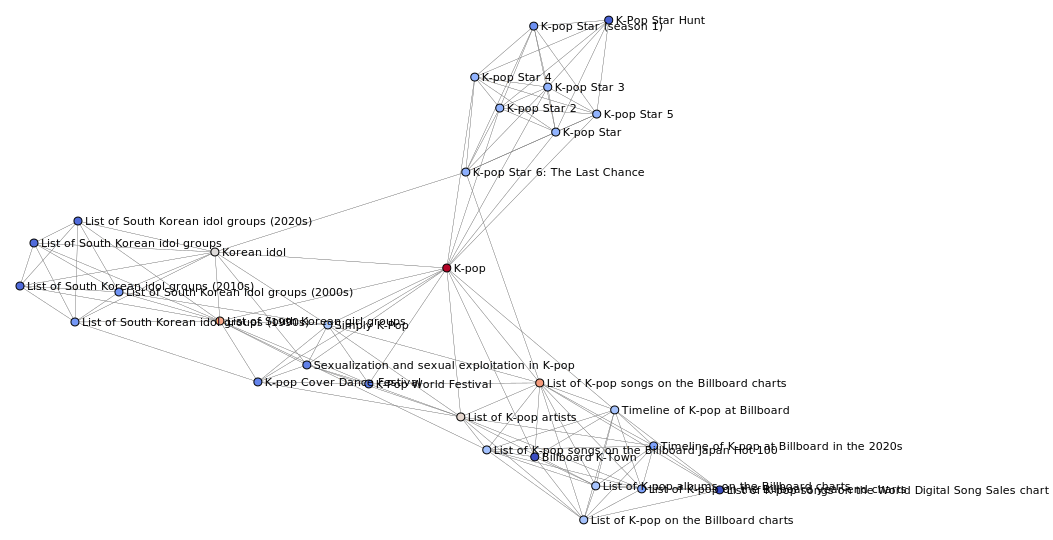

In [7]:
# draw the core

draw_graph(nx.k_core(G, 6), node_size=4, font_size=11, show_names=True, edge_width=0.3)

Now I can see that there are a few parts to this network and that it is not a pure Wilco network. That's normal when using automation to generate network data. It takes exploration to get to the value. Get used to zooming in and out using k_core. It is very useful for this. 

# Identify Nodes of Interest

The next thing I do is identify key nodes of interest. As written about previously, there are ceveral measures and centralities that can be used, such as Page Rank, Betweenness Centrality, Degree Centrality, Closeness Centrality, and on and on. Spend time learning about the different measures of importance. There are very useful.

In [8]:
page_rank = nx.pagerank(G)

pr_df = pd.DataFrame().from_dict(page_rank, orient='index')
pr_df.columns = ['page_rank']
pr_df.sort_values('page_rank', ascending=False, inplace=True)
pr_df.head(10)

page_rank
K-pop                      0.008931
Pop music                  0.006109
Twice                      0.005965
Godfather                  0.005755
Godmother                  0.005755
Kalanchoe brasiliensis     0.005707
Billboard Hot 100          0.005690
Popstars                   0.005637
Hot 100 (disambiguation)   0.005632
O.O (song)                 0.005632

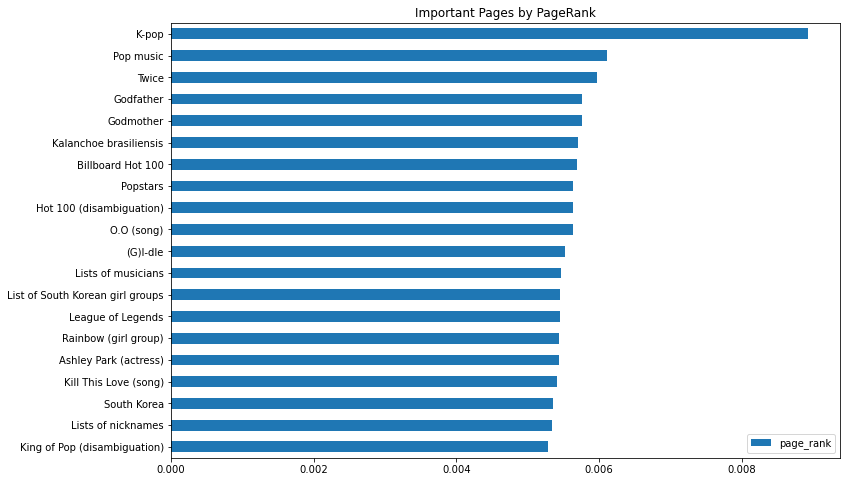

In [9]:
title = 'Important Pages by PageRank'

pr_df.head(20).plot.barh(figsize=(12,8), title=title).invert_yaxis()

This hints at the mixed nature of this network. I can see that Wilco and Jeff Tweedy (lead singer of Wilco) have a drastically higher Page Rank score than the other nodes.

In [10]:
betw_cent = nx.betweenness_centrality(G)

betw_cent_df = pd.DataFrame().from_dict(betw_cent, orient='index')
betw_cent_df.columns = ['betweenness_centrality']
betw_cent_df.sort_values('betweenness_centrality', ascending=False, inplace=True)
betw_cent_df.head(10)

betweenness_centrality
K-pop                                                             0.528901
Honorific nicknames in popular music                              0.153588
K/DA                                                              0.144752
KPOP-LP                                                           0.141208
KPOP (musical)                                                    0.132363
K-pop Hot 100                                                     0.106513
List of K-pop music videos banned by South Kore...                0.097733
List of South Korean girl groups                                  0.092364
List of K-pop artists                                             0.079328
Pop music                                                         0.077123

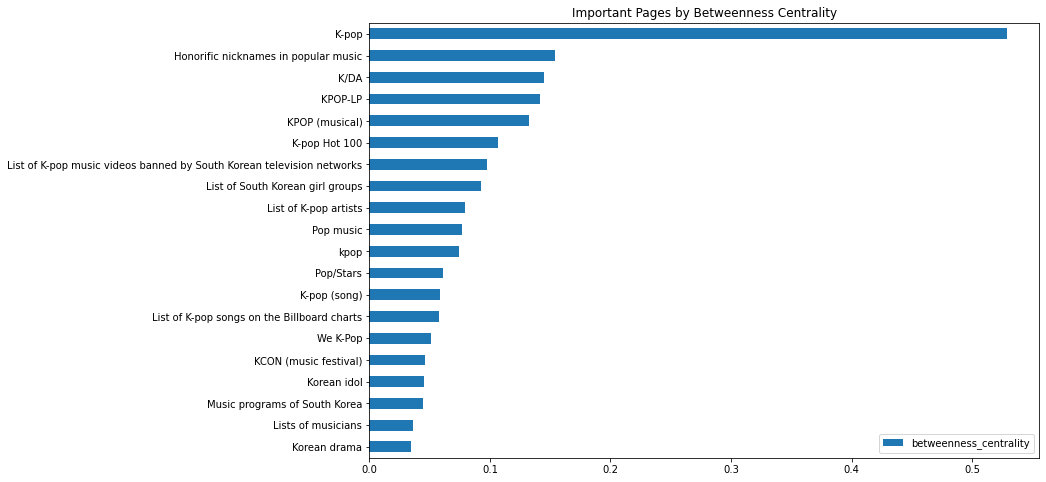

In [11]:
title = 'Important Pages by Betweenness Centrality'

betw_cent_df.head(20).plot.barh(figsize=(12,8), title=title).invert_yaxis()

# Jeff Tweedy, Billy Bragg, Roger Wilco, Tweedy, Glenn Kotche, Jay Farrar, Uncle Tupelo, John Stirratt - Who/What are they?

# Community Detection

We have one large connected component, and this will be great for use in Community Detection. The smaller connected components are communities of their own in this network, split off from the main piece of this network.

In [12]:
def draw_partition(G, partition): 

    import matplotlib.cm as cm 
    import matplotlib.pyplot as plt 

    # draw the graph 
    plt.figure(3,figsize=(12,12)) 
    pos = nx.spring_layout(G) 

    # color the nodes according to their partition 
    cmap = cm.get_cmap('jet', max(partition.values()) + 1) 
    nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=40, cmap=cmap, node_color=list(partition.values())) 
    nx.draw_networkx_edges(G, pos, alpha=0.5, width=0.3) 

    return plt.show() 

In [13]:
# identify communities; set resolution to 0.01 for smaller groups and 1 for larger groups, etc
# play with the number to get communities to the size you want them, or leave it at the default

partition = community_louvain.best_partition(G, resolution=0.2, random_state=1337) 

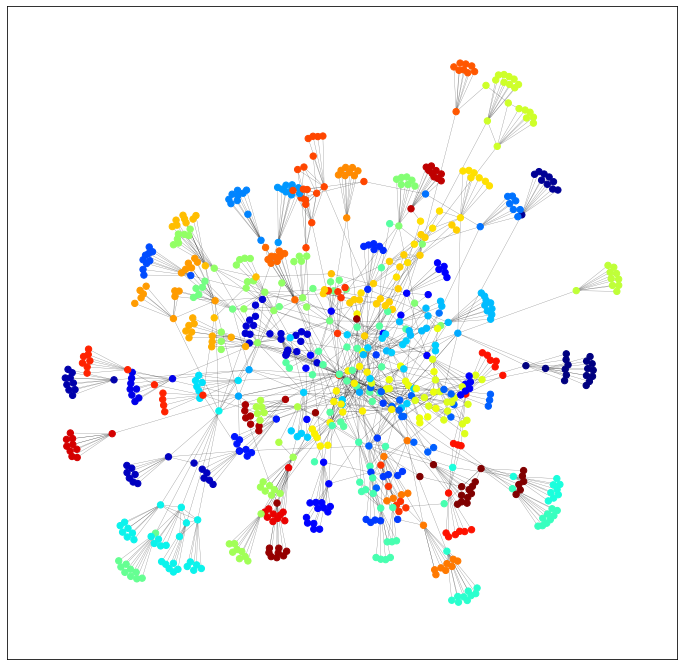

In [14]:
draw_partition(G, partition)

In [15]:
community_df = pd.DataFrame().from_dict(partition, orient='index')
community_df.reset_index(inplace=True)
community_df.columns = ['node', 'community']

# remove junk; identify relevant communities

community_df['community'].value_counts()[0:20]

29    29
20    29
25    24
4     22
18    22
17    21
38    21
12    20
24    20
55    19
34    19
33    19
46    18
49    17
36    17
30    17
0     17
6     17
7     17
41    16
Name: community, dtype: int64

In [16]:
comm_idx = community_df['community'].value_counts()[0:20].index.values
comm_idx

array([29, 20, 25,  4, 18, 17, 38, 12, 24, 55, 34, 33, 46, 49, 36, 30,  0,
        6,  7, 41], dtype=int64)

## Exploring Communities
Below, I am showing the largest community in the network. Looking at some of the node labels, I can see many instances of the word "graph". We are in the right place. 

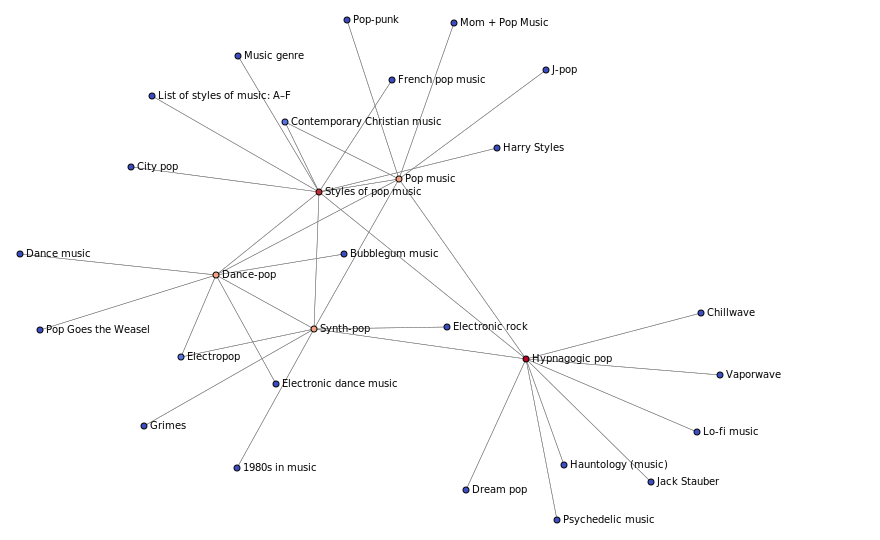

In [17]:
nodes = community_df[community_df['community']==comm_idx[0]]['node'].values

G_comm = G.subgraph(nodes)
G_net_main = G_comm.copy() # we will run community detection off of this at the end

draw_graph(nx.k_core(G_comm, 1), show_names=True, node_size=3)

In [18]:
netsci_nodes = [n for n in sorted(G_net_main.nodes)]
[print(n) for n in netsci_nodes]

1980s in music
Bubblegum music
Chillwave
City pop
Contemporary Christian music
Dance music
Dance-pop
Dream pop
Electronic dance music
Electronic rock
Electropop
French pop music
Grimes
Harry Styles
Hauntology (music)
Hypnagogic pop
J-pop
Jack Stauber
List of styles of music: A–F
Lo-fi music
Mom + Pop Music
Music genre
Pop Goes the Weasel
Pop music
Pop-punk
Psychedelic music
Styles of pop music
Synth-pop
Vaporwave


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

## More Communities!

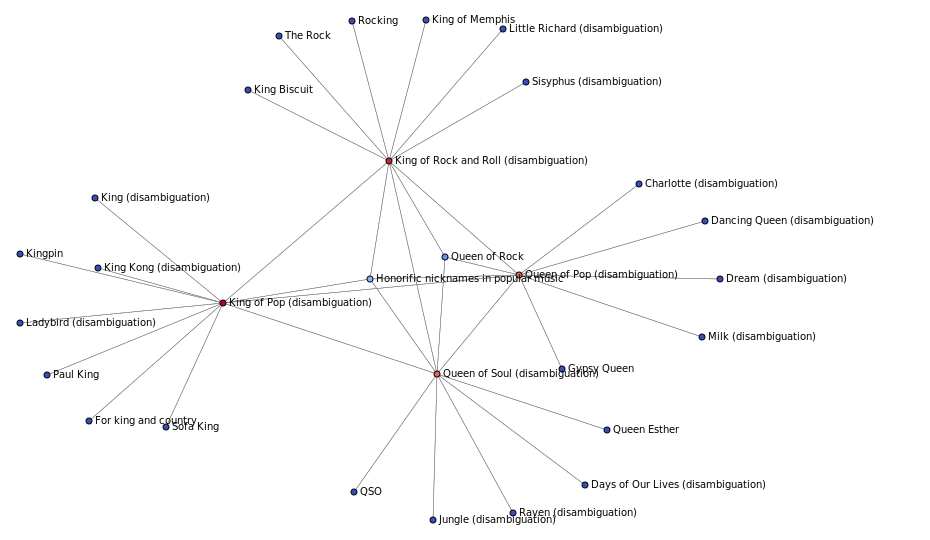

In [19]:
nodes = community_df[community_df['community']==comm_idx[1]]['node'].values

G_comm = G.subgraph(nodes)

draw_graph(nx.k_core(G_comm, 1), show_names=True, node_size=3)

In [20]:
[print(n) for n in sorted(G_comm.nodes)]

Charlotte (disambiguation)
Dancing Queen (disambiguation)
Days of Our Lives (disambiguation)
Dream (disambiguation)
For king and country
Gypsy Queen
Honorific nicknames in popular music
Jungle (disambiguation)
King (disambiguation)
King Biscuit
King Kong (disambiguation)
King of Memphis
King of Pop (disambiguation)
King of Rock and Roll (disambiguation)
Kingpin
Ladybird (disambiguation)
Little Richard (disambiguation)
Milk (disambiguation)
Paul King
QSO
Queen Esther
Queen of Pop (disambiguation)
Queen of Rock
Queen of Soul (disambiguation)
Raven (disambiguation)
Rocking
Sisyphus (disambiguation)
Sofa King
The Rock


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

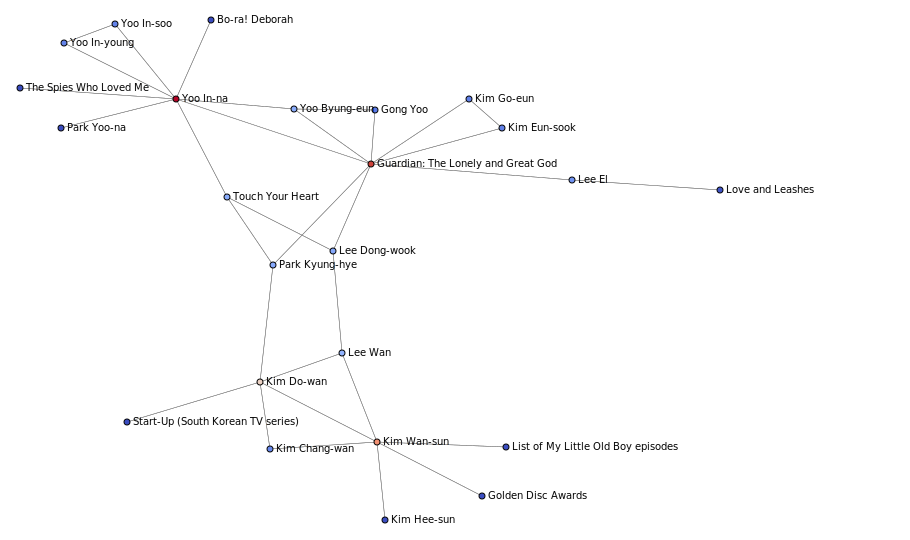

In [21]:
nodes = community_df[community_df['community']==comm_idx[2]]['node'].values

G_comm = G.subgraph(nodes)

draw_graph(nx.k_core(G_comm, 1), show_names=True, node_size=3)

In [22]:
[print(n) for n in sorted(G_comm.nodes)]

Bo-ra! Deborah
Golden Disc Awards
Gong Yoo
Guardian: The Lonely and Great God
Kim Chang-wan
Kim Do-wan
Kim Eun-sook
Kim Go-eun
Kim Hee-sun
Kim Wan-sun
Lee Dong-wook
Lee El
Lee Wan
List of My Little Old Boy episodes
Love and Leashes
Park Kyung-hye
Park Yoo-na
Start-Up (South Korean TV series)
The Spies Who Loved Me
Touch Your Heart
Yoo Byung-eun
Yoo In-na
Yoo In-soo
Yoo In-young


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

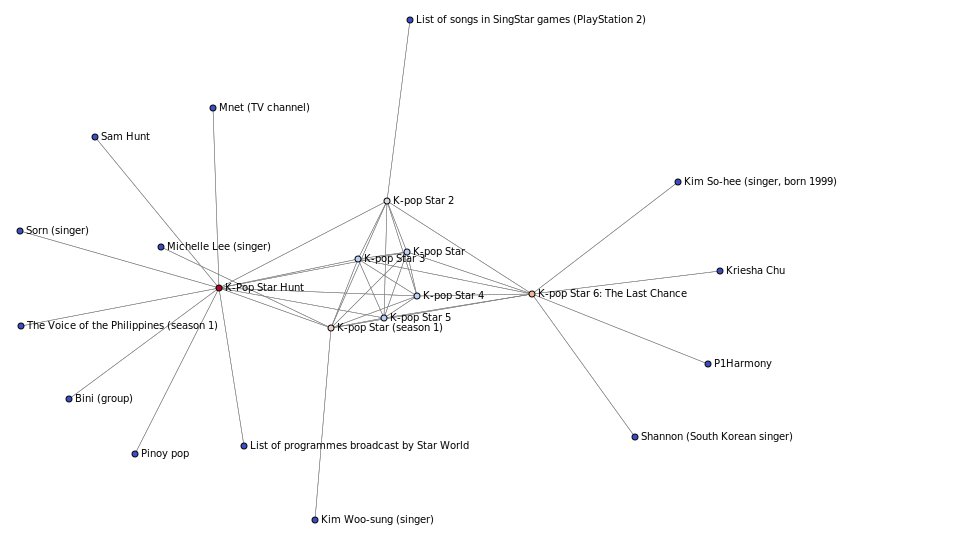

In [23]:
nodes = community_df[community_df['community']==comm_idx[3]]['node'].values

G_comm = G.subgraph(nodes)

draw_graph(nx.k_core(G_comm, 1), show_names=True, node_size=3)

In [24]:
[print(n) for n in sorted(G_comm.nodes)]

Bini (group)
K-Pop Star Hunt
K-pop Star
K-pop Star (season 1)
K-pop Star 2
K-pop Star 3
K-pop Star 4
K-pop Star 5
K-pop Star 6: The Last Chance
Kim So-hee (singer, born 1999)
Kim Woo-sung (singer)
Kriesha Chu
List of programmes broadcast by Star World
List of songs in SingStar games (PlayStation 2)
Michelle Lee (singer)
Mnet (TV channel)
P1Harmony
Pinoy pop
Sam Hunt
Shannon (South Korean singer)
Sorn (singer)
The Voice of the Philippines (season 1)


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

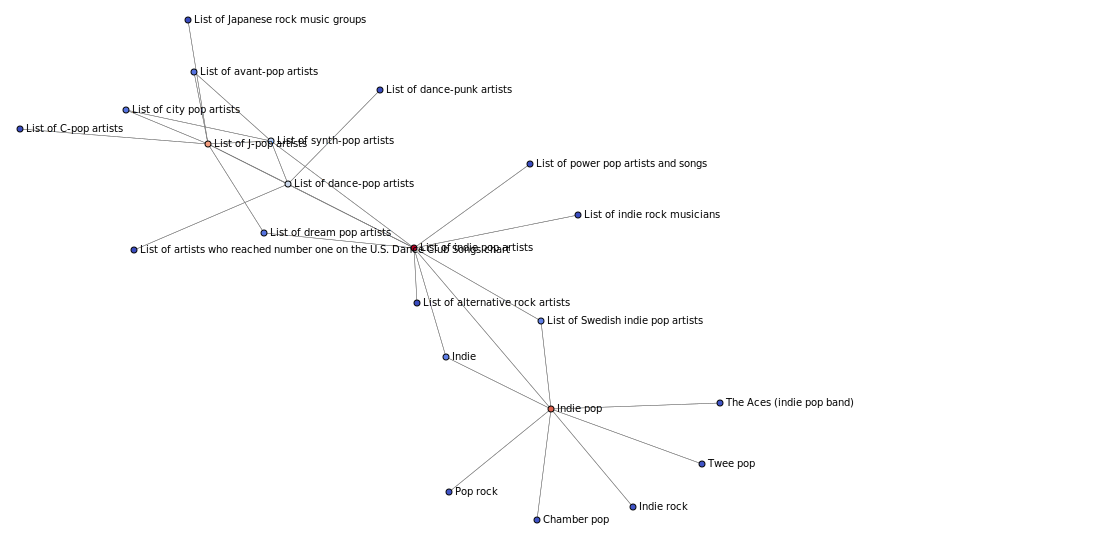

In [25]:
nodes = community_df[community_df['community']==comm_idx[4]]['node'].values

G_comm = G.subgraph(nodes)

draw_graph(nx.k_core(G_comm, 1), show_names=True, node_size=3)

In [26]:
[print(n) for n in sorted(G_comm.nodes)]

Chamber pop
Indie
Indie pop
Indie rock
List of C-pop artists
List of J-pop artists
List of Japanese rock music groups
List of Swedish indie pop artists
List of alternative rock artists
List of artists who reached number one on the U.S. Dance Club Songs chart
List of avant-pop artists
List of city pop artists
List of dance-pop artists
List of dance-punk artists
List of dream pop artists
List of indie pop artists
List of indie rock musicians
List of power pop artists and songs
List of synth-pop artists
Pop rock
The Aces (indie pop band)
Twee pop


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

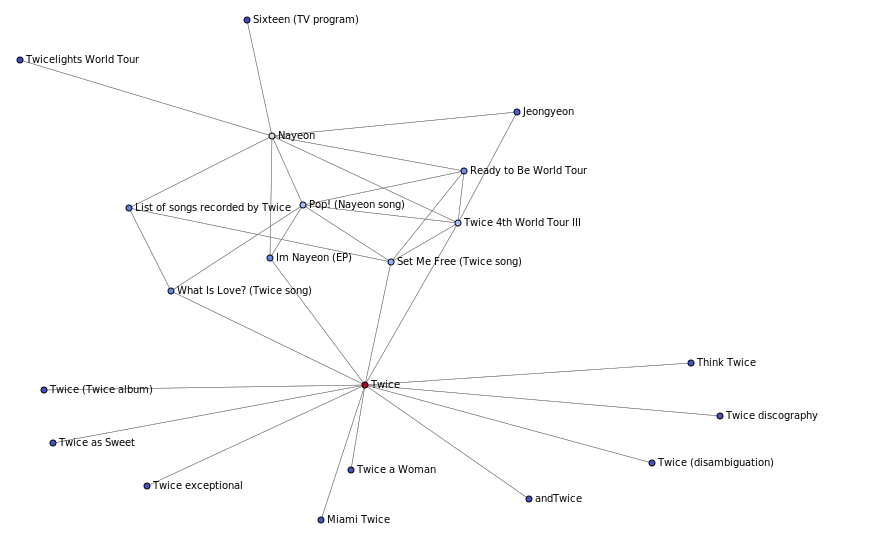

In [27]:
nodes = community_df[community_df['community']==comm_idx[5]]['node'].values

G_comm = G.subgraph(nodes)

draw_graph(nx.k_core(G_comm, 1), show_names=True, node_size=3)

In [28]:
[print(n) for n in sorted(G_comm.nodes)]

Im Nayeon (EP)
Jeongyeon
List of songs recorded by Twice
Miami Twice
Nayeon
Pop! (Nayeon song)
Ready to Be World Tour
Set Me Free (Twice song)
Sixteen (TV program)
Think Twice
Twice
Twice (Twice album)
Twice (disambiguation)
Twice 4th World Tour III
Twice a Woman
Twice as Sweet
Twice discography
Twice exceptional
Twicelights World Tour
What Is Love? (Twice song)
andTwice


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

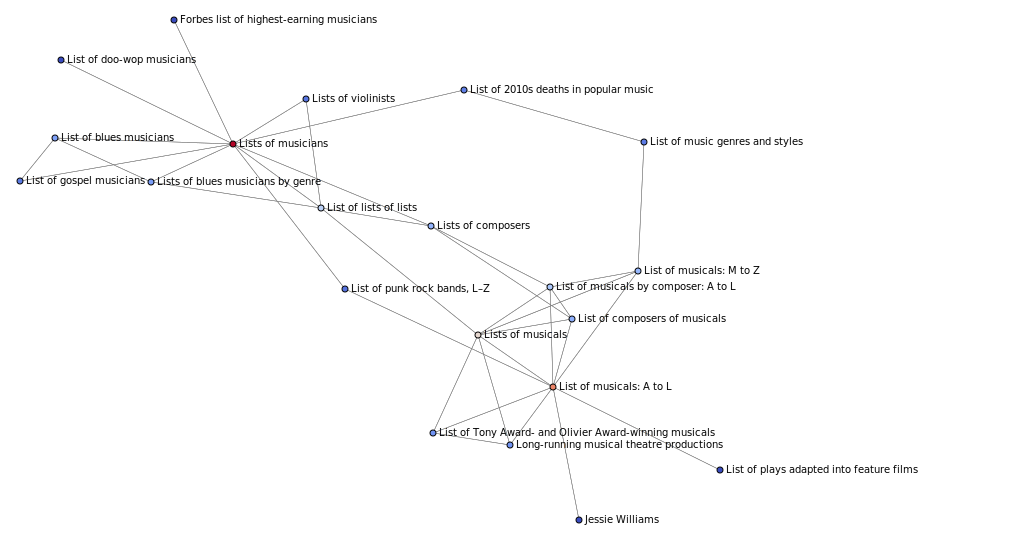

In [29]:
nodes = community_df[community_df['community']==comm_idx[6]]['node'].values

G_comm = G.subgraph(nodes)

draw_graph(nx.k_core(G_comm, 1), show_names=True, node_size=3)

In [30]:
[print(n) for n in sorted(G_comm.nodes)]

Forbes list of highest-earning musicians
Jessie Williams
List of 2010s deaths in popular music
List of Tony Award- and Olivier Award-winning musicals
List of blues musicians
List of composers of musicals
List of doo-wop musicians
List of gospel musicians
List of lists of lists
List of music genres and styles
List of musicals by composer: A to L
List of musicals: A to L
List of musicals: M to Z
List of plays adapted into feature films
List of punk rock bands, L–Z
Lists of blues musicians by genre
Lists of composers
Lists of musicals
Lists of musicians
Lists of violinists
Long-running musical theatre productions


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

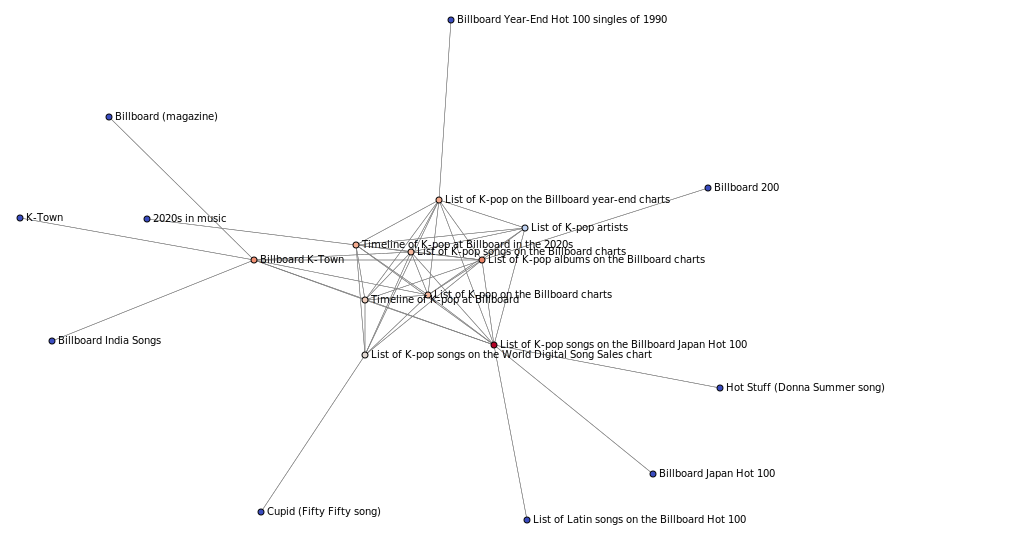

In [31]:
nodes = community_df[community_df['community']==comm_idx[7]]['node'].values

G_comm = G.subgraph(nodes)

draw_graph(nx.k_core(G_comm, 1), show_names=True, node_size=3)

In [32]:
[print(n) for n in sorted(G_comm.nodes)]

2020s in music
Billboard (magazine)
Billboard 200
Billboard India Songs
Billboard Japan Hot 100
Billboard K-Town
Billboard Year-End Hot 100 singles of 1990
Cupid (Fifty Fifty song)
Hot Stuff (Donna Summer song)
K-Town
List of K-pop albums on the Billboard charts
List of K-pop artists
List of K-pop on the Billboard charts
List of K-pop on the Billboard year-end charts
List of K-pop songs on the Billboard Japan Hot 100
List of K-pop songs on the Billboard charts
List of K-pop songs on the World Digital Song Sales chart
List of Latin songs on the Billboard Hot 100
Timeline of K-pop at Billboard
Timeline of K-pop at Billboard in the 2020s


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

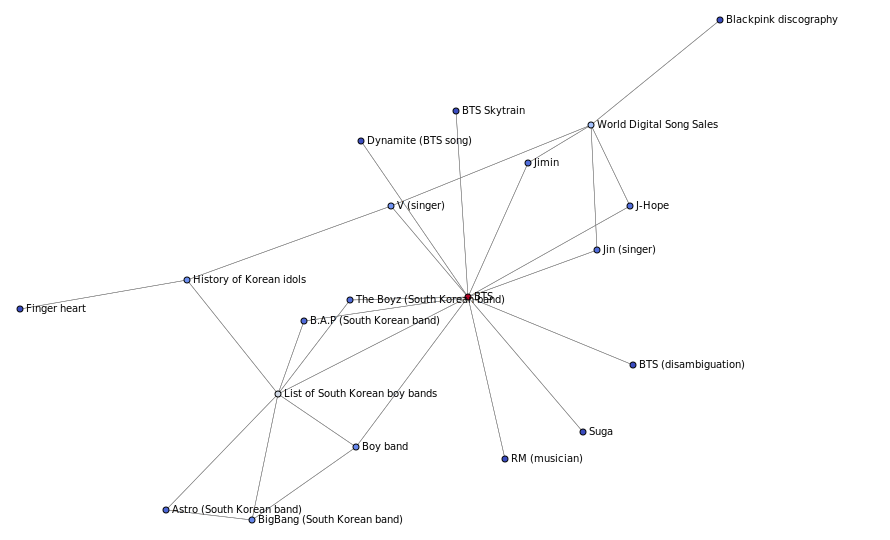

In [33]:
nodes = community_df[community_df['community']==comm_idx[8]]['node'].values

G_comm = G.subgraph(nodes)

draw_graph(nx.k_core(G_comm, 1), show_names=True, node_size=3)

In [34]:
[print(n) for n in sorted(G_comm.nodes)]

Astro (South Korean band)
B.A.P (South Korean band)
BTS
BTS (disambiguation)
BTS Skytrain
BigBang (South Korean band)
Blackpink discography
Boy band
Dynamite (BTS song)
Finger heart
History of Korean idols
J-Hope
Jimin
Jin (singer)
List of South Korean boy bands
RM (musician)
Suga
The Boyz (South Korean band)
V (singer)
World Digital Song Sales


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

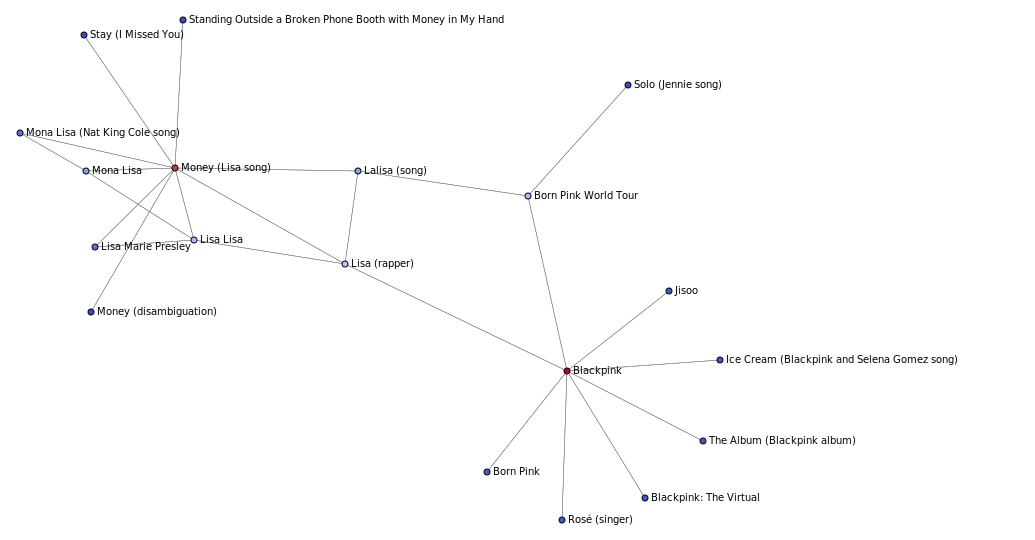

In [35]:
nodes = community_df[community_df['community']==comm_idx[9]]['node'].values

G_comm = G.subgraph(nodes)

draw_graph(nx.k_core(G_comm, 1), show_names=True, node_size=3)

# Ego Networks

Ego Networks are very useful for seeing what nodes exists around a node of interest, and how they are connected. In this dataset, there is a lot of cross-linking from alter nodes (the outer nodes), so we have interesting ego networks to look at. This is not always the case, so it is nice.

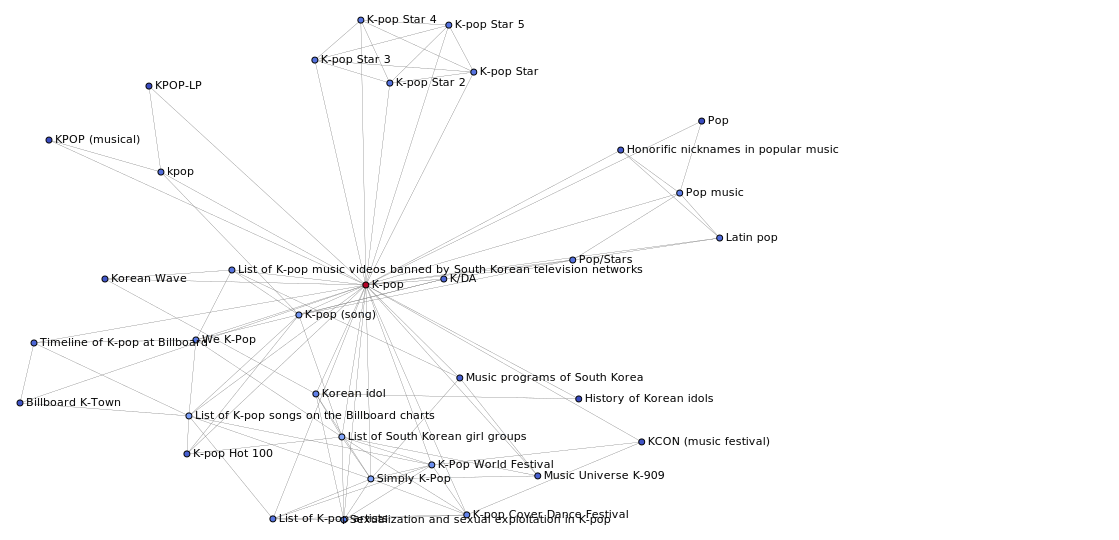

In [36]:
ego = nx.ego_graph(G, 'K-pop')

draw_graph(ego, show_names=True, node_size=3, font_size=11, edge_width=0.2)

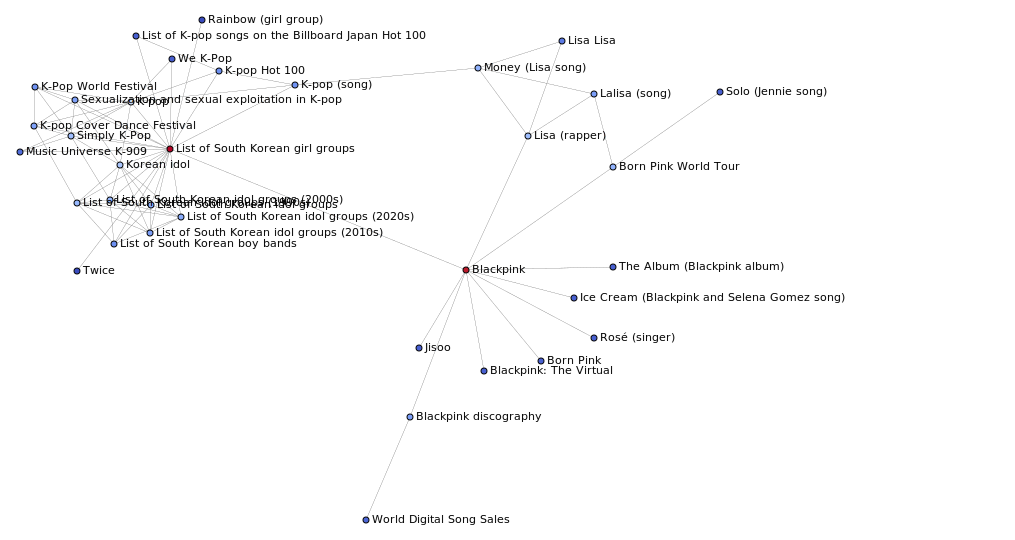

In [38]:
ego = nx.ego_graph(G, 'Blackpink', radius=2)

draw_graph(ego, show_names=True, node_size=3, font_size=11, edge_width=0.2)